<a href="https://colab.research.google.com/github/bongkyunSON/Quant_Factor/blob/main/Quant_CS_TS_test230112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# 패키지 설치
!pip install yfinance --quiet

In [36]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
import yfinance as yf

In [37]:
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
data = data.droplevel(0, axis=1).resample('W').last()

[*********************100%***********************]  9 of 9 completed


In [38]:
data

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2010-01-10,26.277023,39.452450,9.772843,22.691431,19.002804,18.737925,19.398191,25.448112,25.633104
2010-01-17,25.434238,38.772007,9.593057,22.551786,18.689383,18.878973,19.518167,25.800442,25.287283
2010-01-24,23.801332,36.835373,9.105058,21.597589,17.864611,18.540464,18.829887,25.352016,24.477539
2010-01-31,22.680119,35.657696,9.105058,21.240728,17.287268,18.476988,18.646761,25.047722,24.384762
2010-02-07,22.935966,35.487576,8.950948,21.101089,17.378004,18.321840,18.261578,24.687382,24.266676
...,...,...,...,...,...,...,...,...,...
2022-12-18,78.570999,83.500000,33.490002,97.633995,127.115005,74.327003,69.908005,134.973999,133.544006
2022-12-25,78.519997,87.059998,33.950001,98.389999,124.599998,75.180000,70.910004,136.100006,129.429993
2023-01-01,77.680000,87.470001,34.200001,98.209999,124.440002,74.550003,70.500000,135.850006,129.160004


In [77]:
class CrossSectional:

    def __init__(self, rebal_price: pd.DataFrame, param: int):

        # 연율화 패러미터
        self.param = param

        # 일별 수익률
        self.rets = rebal_price.pct_change().dropna()

        # 기대수익률
        self.er = np.array(self.rets * self.param)

        # 변동성
        self.vol = np.array(self.rets.rolling(
            self.param).std() * np.sqrt(self.param))

        # 공분산행렬
        cov = self.rets.rolling(self.param).cov().dropna() * self.param
        self.cov = cov.values.reshape(
            int(cov.shape[0]/cov.shape[1]), cov.shape[1], cov.shape[1])

    # EW

    def ew(self, er):
        noa = er.shape[0]
        weights = np.ones_like(er) * (1/noa)
        return weights

    # MSR
    def msr(self, er, cov):
        noa = er.shape[0]
        init_guess = np.repeat(1/noa, noa)

        bounds = ((0.0, 1.0), ) * noa
        weights_sum_to_1 = {'type': 'eq',
                            'fun': lambda weights: np.sum(weights) - 1}

        def neg_sharpe(weights, er, cov):
            r = weights.T @ er
            vol = np.sqrt(weights.T @ cov @ weights)
            return - r / vol

        weights = minimize(neg_sharpe,
                        init_guess,
                        args=(er, cov),
                        method='SLSQP',
                        constraints=(weights_sum_to_1,),
                        bounds=bounds)

        return weights.x

    # GMV
    def gmv(self, cov):
        noa = cov.shape[0]
        init_guess = np.repeat(1/noa, noa)

        bounds = ((0.0, 1.0), ) * noa
        weights_sum_to_1 = {'type': 'eq',
                            'fun': lambda weights: np.sum(weights) - 1}

        def port_vol(weights, cov):
            vol = np.sqrt(weights.T @ cov @ weights)
            return vol

        weights = minimize(port_vol, init_guess, args=(
            cov), method='SLSQP', constraints=(weights_sum_to_1,), bounds=bounds)

        return weights.x

    # MDP
    def mdp(self, vol, cov):
        noa = vol.shape[0]
        init_guess = np.repeat(1/noa, noa)
        bounds = ((0.0, 1.0), ) * noa

        weights_sum_to_1 = {'type': 'eq',
                            'fun': lambda weights: np.sum(weights) - 1}

        def neg_div_ratio(weights, vol, cov):
            weighted_vol = weights.T @ vol
            port_vol = np.sqrt(weights.T @ cov @ weights)
            return - weighted_vol / port_vol

        weights = minimize(neg_div_ratio,
                        init_guess,
                        args=(vol, cov),
                        method='SLSQP',
                        constraints=(weights_sum_to_1,),
                        bounds=bounds)

        return weights.x

    # RP
    def rp(self, cov):
        noa = cov.shape[0]
        init_guess = np.repeat(1/noa, noa)
        bounds = ((0.0, 1.0), ) * noa
        target_risk = np.repeat(1/noa, noa)

        weights_sum_to_1 = {'type': 'eq',
                            'fun': lambda weights: np.sum(weights) - 1}

        def msd_risk(weights, target_risk, cov):

            port_var = weights.T @ cov @ weights
            marginal_contribs = cov @ weights

            risk_contribs = np.multiply(
                marginal_contribs, weights.T) / port_var

            w_contribs = risk_contribs
            return ((w_contribs - target_risk)**2).sum()

        weights = minimize(msd_risk,
                        init_guess,
                        args=(target_risk, cov),
                        method='SLSQP',
                        constraints=(weights_sum_to_1,),
                        bounds=bounds)
        return weights.x

        # EMV
        def emv(self, vol):
            inv_vol = 1 / vol
            weights = inv_vol / inv_vol.sum()

            return weights

    def run(self, cs_model):
        # 빈 딕셔너리
        backtest_dict = {}
        
        # 일별 수익률 데이터프레임
        rets = self.rets
        
        # 횡적 배분 모델 선택 및 실행
        for i, index in enumerate(rets.index[self.param-1:]):
            if cs_model == 'EW':
                backtest_dict[index] = self.ew(self.er[i])
            elif cs_model == 'MSR':
                backtest_dict[index] = self.msr(self.er[i], self.cov[i])
            elif cs_model == 'GMV':
                backtest_dict[index] = self.gmv(self.cov[i])
            elif cs_model == 'MDP':
                backtest_dict[index] = self.mdp(self.vol[i], self.cov[i])
            elif cs_model == 'EMV':
                backtest_dict[index] = self.emv(self.vol[i])
            elif cs_model == 'RP':
                backtest_dict[index] = self.rp(self.cov[i])

        # 횡적 가중치 데이터프레임
        cs_weights = pd.DataFrame(list(backtest_dict.values()), index=backtest_dict.keys(), columns=rets.columns)
        cs_weights.fillna(0, inplace=True)

        # 횡적 배분 모델 자산 수익률
        cs_rets = cs_weights.shift(1) * rets.iloc[self.param-1:,:]

        # 횡적 배분 모델 포트폴리오 수익률
        cs_port_rets = cs_rets.sum(axis=1)
        return cs_port_rets, cs_weights

In [78]:
engine = CrossSectional(rebal_price = data, param=52)

In [79]:
res = engine.run(cs_model='MSR')

In [80]:
print(res)

(2011-01-09    0.000000
2011-01-16    0.003430
2011-01-23   -0.002637
2011-01-30   -0.012758
2011-02-06    0.046813
                ...   
2022-12-18   -0.017756
2022-12-25   -0.021624
2023-01-01   -0.008273
2023-01-08    0.015923
2023-01-15    0.001713
Length: 628, dtype: float64,                      XLB           XLE           XLF           XLI  \
2011-01-09  1.335043e-14  1.545986e-14  6.078471e-15  0.000000e+00   
2011-01-16  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2011-01-23  0.000000e+00  0.000000e+00  1.000000e+00  1.042777e-13   
2011-01-30  1.000000e+00  6.050715e-15  0.000000e+00  1.665335e-15   
2011-02-06  1.668442e-11  0.000000e+00  1.683593e-11  1.517477e-11   
...                  ...           ...           ...           ...   
2022-12-18  6.037018e-16  1.250358e-01  0.000000e+00  0.000000e+00   
2022-12-25  2.046059e-01  0.000000e+00  5.904370e-14  0.000000e+00   
2023-01-01  3.259868e-14  5.550586e-01  4.449414e-01  0.000000e+00   
2023-01-08  0.000

In [51]:
# 수익률
rets = data.pct_change().fillna(0)

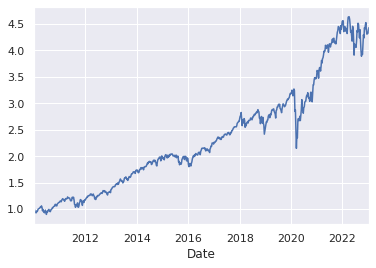

In [52]:
# 동일 비중 포트폴리오 수익률
port_rets = rets.mean(axis=1)

# 백테스팅 결과
(1 + port_rets).cumprod().plot()

In [119]:
class TimeSeries:

    def __init__(self, port_rets, 
                 param: int, 
                 cs_port_rets: pd.DataFrame, 
                 cs_weights: pd.DataFrame,
                 rebal_price: pd.DataFrame
                 ):
        self.port_rets = port_rets
        self.param = param
        self.cs_port_rets = cs_port_rets
        self.cs_weights = cs_weights
        self.rets = rebal_price.pct_change().dropna()

        
        # 거래비용
        self.cost = 0.0005

    # VT
    def vt(self, port_rets, param, vol_target=0.1):
        vol = port_rets.rolling(param).std().fillna(0) * np.sqrt(param)
        weights = (
            vol_target / vol).replace([np.inf, -np.inf], 0).shift(1).fillna(0)
        weights[weights > 1] = 1
        return weights

    # CVT
    def cvt(self, port_rets, param, delta=0.01, cvar_target=0.05):
        def calculate_CVaR(rets, delta=0.01):
            VaR = rets.quantile(delta)
            return rets[rets <= VaR].mean()

        rolling_CVaR = - \
            port_rets.rolling(param).apply(
                calculate_CVaR, args=(delta,)).fillna(0)
        weights = (
            cvar_target / rolling_CVaR).replace([np.inf, -np.inf], 0).shift(1).fillna(0)
        weights[weights > 1] = 1
        return weights

    # KL
    def kl(self, port_rets, param):
        sharpe_ratio = (port_rets.rolling(param).mean() *
                        np.sqrt(param) / port_rets.rolling(param).std())
        weights = pd.Series(2 * norm.cdf(sharpe_ratio) - 1,
                            index=port_rets.index).fillna(0)
        weights[weights < 0] = 0
        weights = weights.shift(1).fillna(0)
        return weights

    # CPPI 

    def cppi(self, port_rets, m=3, floor=0.7, init_val=1):
        n_steps = len(port_rets)
        port_value = init_val
        floor_value = init_val * floor
        peak = init_val
        """
        init_val = 스타트 시점
        m = 래버리지 승수
        floor = 하한선 비율 (e.g. init_val 이 1이고 floor이 0.7이면 하한선은 30%)
        """
        port_history = pd.Series(dtype=np.float64).reindex_like(port_rets)
        weight_history = pd.Series(dtype=np.float64).reindex_like(port_rets)
        floor_history = pd.Series(dtype=np.float64).reindex_like(port_rets)

        for step in range(n_steps):
            peak = np.maximum(peak, port_value)
            floor_value = peak * floor

            cushion = (port_value - floor_value) / port_value
            weight = m * cushion

            risky_alloc = port_value * weight
            safe_alloc = port_value * (1 - weight)
            port_value = risky_alloc * (1 + port_rets.iloc[step]) + safe_alloc

            port_history.iloc[step] = port_value
            weight_history.iloc[step] = weight
            floor_history.iloc[step] = floor_value

        return weight_history.shift(1).fillna(0)

    def transaction_cost(self, weights_df, rets_df, cost=0.0005):
        # 이전 기의 투자 가중치
        prev_weights_df = (weights_df.shift(1).fillna(0) * (1 + rets_df.iloc[self.param-1:,:])) \
        .div((weights_df.shift(1).fillna(0) * (1 + rets_df.iloc[self.param-1:,:])).sum(axis=1), axis=0)

        # 거래비용 데이터프레임
        cost_df = abs(weights_df - prev_weights_df) * cost
        cost_df.fillna(0, inplace=True)

    # 백테스팅 실행 함수
    def run(self, ts_model, cost):
        # 빈 딕셔너리
        backtest_dict = {}
        
        # 일별 수익률 데이터프레임
        rets = self.rets 

        # 종적 배분 모델 선택 및 실행
        if ts_model == 'VT':
            ts_weights = self.vt(self.cs_port_rets, self.param)
        elif ts_model == 'CVT':
            ts_weights = (self.cvt(self.cs_port_rets, self.param))
        elif ts_model == 'KL':
            ts_weights = (self.kl(self.cs_port_rets, self.param))
        elif ts_model == 'CPPI':
            ts_weights = (self.cppi(self.cs_port_rets))
        elif ts_model == None:
            ts_weights = 1

        # 최종 포트폴리오 투자 가중치
        port_weights = self.cs_weights.multiply(ts_weights, axis=0)

        # 거래비용 데이터프레임
        cost = self.transaction_cost(port_weights, rets)

        # 최종 포트폴리오 자산별 수익률
        port_asset_rets = port_weights.shift() * rets - cost

        # 최종 포트폴리오 수익률 
        port_rets = port_asset_rets.sum(axis=1)
        port_rets.index = pd.to_datetime(port_rets.index).strftime("%Y-%m-%d")

        return port_weights, port_asset_rets, port_rets

In [120]:
engine = TimeSeries(
                    port_rets=port_rets, 
                    param=52, 
                    cs_port_rets = res[0], 
                    cs_weights = res[1],
                    rebal_price = data
                    
                    )

In [121]:
engine.run(ts_model='VT', cost = 0.0005)

TypeError: ignored

In [ ]:
engine.vt

<bound method TimeSeries.vt of <__main__.TimeSeries object at 0x7f4adf6cfac0>>

In [ ]:
class CrossSectional:

    def __init__(self, rebal_price: pd.DataFrame, param: int):

        # 연율화 패러미터
        self.param = param

        # 일별 수익률
        self.rets = rebal_price.pct_change().dropna()

        # 기대수익률
        self.er = np.array(self.rets * self.param)

        # 변동성
        self.vol = np.array(self.rets.rolling(
            self.param).std() * np.sqrt(self.param))

        # 공분산행렬
        cov = self.rets.rolling(self.param).cov().dropna() * self.param
        self.cov = cov.values.reshape(
            int(cov.shape[0]/cov.shape[1]), cov.shape[1], cov.shape[1])

        # 거래비용
        self.cost = 0.0005

        # EW

    def ew(self, er):
        noa = er.shape[0]
        weights = np.ones_like(er) * (1/noa)
        return weights

    # MSR
    def msr(self, er, cov):
        noa = er.shape[0]
        init_guess = np.repeat(1/noa, noa)

        bounds = ((0.0, 1.0), ) * noa
        weights_sum_to_1 = {'type': 'eq',
                            'fun': lambda weights: np.sum(weights) - 1}

        def neg_sharpe(weights, er, cov):
            r = weights.T @ er
            vol = np.sqrt(weights.T @ cov @ weights)
            return - r / vol

        weights = minimize(neg_sharpe,
                           init_guess,
                           args=(er, cov),
                           method='SLSQP',
                           constraints=(weights_sum_to_1,),
                           bounds=bounds)

        return weights.x

    # GMV
    def gmv(self, cov):
        noa = cov.shape[0]
        init_guess = np.repeat(1/noa, noa)

        bounds = ((0.0, 1.0), ) * noa
        weights_sum_to_1 = {'type': 'eq',
                            'fun': lambda weights: np.sum(weights) - 1}

        def port_vol(weights, cov):
            vol = np.sqrt(weights.T @ cov @ weights)
            return vol

        weights = minimize(port_vol, init_guess, args=(
            cov), method='SLSQP', constraints=(weights_sum_to_1,), bounds=bounds)

        return weights.x

    # MDP
    def mdp(self, vol, cov):
        noa = vol.shape[0]
        init_guess = np.repeat(1/noa, noa)
        bounds = ((0.0, 1.0), ) * noa

        weights_sum_to_1 = {'type': 'eq',
                            'fun': lambda weights: np.sum(weights) - 1}

        def neg_div_ratio(weights, vol, cov):
            weighted_vol = weights.T @ vol
            port_vol = np.sqrt(weights.T @ cov @ weights)
            return - weighted_vol / port_vol

        weights = minimize(neg_div_ratio,
                           init_guess,
                           args=(vol, cov),
                           method='SLSQP',
                           constraints=(weights_sum_to_1,),
                           bounds=bounds)

        return weights.x

    # RP
    def rp(self, cov):
        noa = cov.shape[0]
        init_guess = np.repeat(1/noa, noa)
        bounds = ((0.0, 1.0), ) * noa
        target_risk = np.repeat(1/noa, noa)

        weights_sum_to_1 = {'type': 'eq',
                            'fun': lambda weights: np.sum(weights) - 1}

        def msd_risk(weights, target_risk, cov):

            port_var = weights.T @ cov @ weights
            marginal_contribs = cov @ weights

            risk_contribs = np.multiply(
                marginal_contribs, weights.T) / port_var

            w_contribs = risk_contribs
            return ((w_contribs - target_risk)**2).sum()

        weights = minimize(msd_risk,
                           init_guess,
                           args=(target_risk, cov),
                           method='SLSQP',
                           constraints=(weights_sum_to_1,),
                           bounds=bounds)
        return weights.x

    # EMV
    def emv(self, vol):
        inv_vol = 1 / vol
        weights = inv_vol / inv_vol.sum()

        return weights

In [ ]:
engine2 = CrossSectional(data, param=52)

In [ ]:
engine2.msr

<bound method CrossSectional.msr of <__main__.CrossSectional object at 0x7f4ae3060f40>>